In [1]:
import os
import pandas as pd

In [2]:
from datetime import datetime, timedelta
date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

df3 = pd.read_csv("processed_data.csv", date_parser=date_parser, parse_dates=["Date"], dtype={"Season": str})

In [3]:
len(df3.groupby("AwayTeam").count())

41

In [4]:
columns_req = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR', 'Season',
               "HS", "AS", "HST", "AST", "HF", "AF", "HC", "AC", "HY", "AY", "HR", "AR"]

df4 = df3[columns_req]
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6214 entries, 0 to 6213
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      6214 non-null   datetime64[ns]
 1   HomeTeam  6214 non-null   object        
 2   AwayTeam  6214 non-null   object        
 3   FTHG      6214 non-null   int64         
 4   FTAG      6214 non-null   int64         
 5   FTR       6214 non-null   object        
 6   Season    6214 non-null   object        
 7   HS        6214 non-null   int64         
 8   AS        6214 non-null   int64         
 9   HST       6214 non-null   int64         
 10  AST       6214 non-null   int64         
 11  HF        6214 non-null   int64         
 12  AF        6214 non-null   int64         
 13  HC        6214 non-null   int64         
 14  AC        6214 non-null   int64         
 15  HY        6214 non-null   int64         
 16  AY        6214 non-null   int64         
 17  HR        6214

In [5]:
def find_time_interval(time_series):
    return abs(min(time_series) - max(time_series)) / 7

In [6]:
min(df4["Date"])

Timestamp('2005-08-13 00:00:00')

In [7]:
import math

In [8]:
mins = abs(min(df4["Date"]) - max(df4["Date"])).total_seconds() / 60
hour = mins / 60
days = hour / 24
weeks = days / 7
math.ceil(weeks)

851

In [9]:
dummy_teams = sorted(df4.HomeTeam.unique())
dummy_teams_dict = dict()

for i in range(len(dummy_teams)):
    dummy_teams_dict[dummy_teams[i]] = [i for i in range(math.ceil(weeks) + 1)]

dummy_df = pd.DataFrame(dummy_teams_dict)

df5 = dummy_df.T

for col in df5.columns:
    df5[col].values[:] = 0

dates = list(dummy_df.T.columns)
initial_date_str = min(df4.Date).strftime("%Y-%m-%d").split('-')
initial = datetime(int(initial_date_str[0]),
                   int(initial_date_str[1]),
                   int(initial_date_str[2]))# date
dates_t = []

for i in range(len(dates)):
    delta = i * timedelta(days = 7)
    dates_t.append(initial + delta)

In [10]:
df5.columns = dates_t
df5.head()

,2005-08-13,2005-08-20,2005-08-27,2005-09-03,2005-09-10,2005-09-17,2005-09-24,2005-10-01,2005-10-08,2005-10-15,...,2021-10-02,2021-10-09,2021-10-16,2021-10-23,2021-10-30,2021-11-06,2021-11-13,2021-11-20,2021-11-27,2021-12-04
Arsenal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aston Villa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Birmingham,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Blackburn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Blackpool,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
from tqdm import tqdm

def find_time_interval(date, series):
    for time_i in series:
        if date <= time_i:
            return time_i.strftime("%Y-%m-%d")
        
def find_team_idx(team, dfIndex):
    return list(dfIndex).index(team)

def find_goals_scored(df_ref, df_result):
    tmp = df_result.copy()
    for i in tqdm(range(len(dummy_teams))):
        home_teams = df_ref.loc[(df_ref["HomeTeam"] == dummy_teams[i])].reset_index(drop=True)
        away_teams = df_ref.loc[(df_ref["AwayTeam"] == dummy_teams[i])].reset_index(drop=True)

        for idx, game in home_teams.iterrows():
            time_i = find_time_interval(game["Date"], tmp.columns)
            team_idx = find_team_idx(game["HomeTeam"], tmp.index)
            goals_scored = game["FTHG"]
            tmp.iloc[team_idx][time_i] += goals_scored

        for idx, game in away_teams.iterrows():
            time_i = find_time_interval(game["Date"], tmp.columns)
            team_idx = find_team_idx(game["AwayTeam"], tmp.index)
            goals_scored = game["FTAG"]
            tmp.iloc[team_idx][time_i] += goals_scored
            
    return tmp

def find_goals_conceded(df_ref, df_result):
    tmp = df_result.copy()
    for i in tqdm(range(len(dummy_teams))):
        home_teams = df_ref.loc[(df_ref["HomeTeam"] == dummy_teams[i])].reset_index(drop=True)
        away_teams = df_ref.loc[(df_ref["AwayTeam"] == dummy_teams[i])].reset_index(drop=True)

        for idx, game in home_teams.iterrows():
            time_i = find_time_interval(game["Date"], tmp.columns)
            team_idx = find_team_idx(game["AwayTeam"], tmp.index)
            goals_conceded = game["FTHG"]
            tmp.iloc[team_idx][time_i] += goals_conceded

        for idx, game in away_teams.iterrows():
            time_i = find_time_interval(game["Date"], tmp.columns)
            team_idx = find_team_idx(game["HomeTeam"], tmp.index)
            goals_conceded = game["FTAG"]
            tmp.iloc[team_idx][time_i] += goals_conceded
            
    return tmp


In [12]:
teams_scored = find_goals_scored(df4, df5)
teams_conceded = find_goals_conceded(df4, df5)

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:12<00:00,  3.37it/s]


In [13]:
teams_scored.head()

,2005-08-13,2005-08-20,2005-08-27,2005-09-03,2005-09-10,2005-09-17,2005-09-24,2005-10-01,2005-10-08,2005-10-15,...,2021-10-02,2021-10-09,2021-10-16,2021-10-23,2021-10-30,2021-11-06,2021-11-13,2021-11-20,2021-11-27,2021-12-04
Arsenal,0,2,4,0,1,0,2,0,1,1,...,3,0,0,5,2,0,1,0,2,0
Aston Villa,2,0,2,0,0,1,1,0,2,0,...,0,1,2,1,0,1,0,2,2,1
Birmingham,0,1,3,0,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Blackburn,1,2,0,0,0,0,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
Blackpool,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
teams_conceded.head()

,2005-08-13,2005-08-20,2005-08-27,2005-09-03,2005-09-10,2005-09-17,2005-09-24,2005-10-01,2005-10-08,2005-10-15,...,2021-10-02,2021-10-09,2021-10-16,2021-10-23,2021-10-30,2021-11-06,2021-11-13,2021-11-20,2021-11-27,2021-12-04
Arsenal,0,0,2,0,2,0,0,0,0,2,...,1,0,0,3,0,0,0,4,0,0
Aston Villa,2,1,1,0,0,5,2,0,3,0,...,0,2,3,3,0,5,0,0,1,2
Birmingham,0,2,5,0,1,1,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Blackburn,3,1,1,0,0,0,4,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Blackpool,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
def generate_team_dict(stat):
    teams_dict = dict()
    if stat == "GS":
        for team in list(df5.index):

            tmp = teams_scored.T[[team]]
            rows_n = len(tmp)
            team_mapper = dict()
            lst_of_idx = []

            for idx in tmp.index:
                lst_of_idx.append(datetime.strftime(idx, "%Y-%m-%d"))

            for val_idx in range(len(lst_of_idx)):
                team_mapper[lst_of_idx[val_idx]] = tmp[team][val_idx]

            teams_dict[team] = team_mapper
            
    if stat == "GC":
        for team in list(df5.index):

            tmp = teams_conceded.T[[team]]
            rows_n = len(tmp)
            team_mapper = dict()
            lst_of_idx = []

            for idx in tmp.index:
                lst_of_idx.append(datetime.strftime(idx, "%Y-%m-%d"))

            for val_idx in range(len(lst_of_idx)):
                team_mapper[lst_of_idx[val_idx]] = tmp[team][val_idx]

            teams_dict[team] = team_mapper
            
    return teams_dict

In [16]:
df4["Date_interval"] = df4.Date.apply(lambda x: find_time_interval(x, df5.columns))
df4

<ipython-input-16-ad0d0eaf68e9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["Date_interval"] = df4.Date.apply(lambda x: find_time_interval(x, df5.columns))


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Date_interval
0,2005-08-13,Aston Villa,Bolton,2,2,D,0506,3,13,2,6,14,16,7,8,0,2,0,0,2005-08-13
1,2005-08-13,Everton,Man United,0,2,A,0506,10,12,5,5,15,14,8,6,3,1,0,0,2005-08-13
2,2005-08-13,Fulham,Birmingham,0,0,D,0506,15,7,7,4,12,13,6,6,1,2,0,0,2005-08-13
3,2005-08-13,Man City,West Brom,0,0,D,0506,15,13,8,3,13,11,3,6,2,3,0,0,2005-08-13
4,2005-08-13,Middlesbrough,Liverpool,0,0,D,0506,4,16,2,7,17,11,5,0,2,3,1,0,2005-08-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,2021-12-01,Watford,Chelsea,1,2,A,2122,13,8,6,4,18,16,6,0,4,3,0,0,2021-12-04
6210,2021-12-01,West Ham,Brighton,1,1,D,2122,14,9,6,3,10,8,9,5,1,1,0,0,2021-12-04
6211,2021-12-01,Wolves,Burnley,0,0,D,2122,16,6,2,1,5,7,5,5,2,3,0,0,2021-12-04
6212,2021-12-01,Aston Villa,Man City,1,2,A,2122,9,17,3,7,8,12,4,11,0,0,0,0,2021-12-04


In [17]:
def apply_stat(stat, stat_dict, df_result):
    tmp = df_result.copy()
    
    if stat == "HTGS":
        tmp_ls = []
        for idx, row in tmp.iterrows():
            tmp_ls.append(stat_dict[row["HomeTeam"]][row["Date_interval"]])
        tmp[stat] = pd.Series(tmp_ls)
        
    if stat == "HTGSCum":
        tmp_ls = []
        for idx, row in tmp.iterrows():
            tmp_ls.append(stat_dict[row["Season"]][row["HomeTeam"]][row["Date_interval"]])
        tmp[stat] = pd.Series(tmp_ls)
        
    if stat == "ATGS":
        tmp_ls = []
        for idx, row in tmp.iterrows():
            tmp_ls.append(stat_dict[row["AwayTeam"]][row["Date_interval"]])
        tmp[stat] = pd.Series(tmp_ls)
    if stat == "ATGSCum":
        tmp_ls = []
        for idx, row in tmp.iterrows():
            tmp_ls.append(stat_dict[row["Season"]][row["AwayTeam"]][row["Date_interval"]])
        tmp[stat] = pd.Series(tmp_ls)
        
    if stat == "HTGC":
        tmp_ls = []
        for idx, row in tmp.iterrows():
            tmp_ls.append(stat_dict[row["HomeTeam"]][row["Date_interval"]])
        tmp[stat] = pd.Series(tmp_ls)
    if stat == "HTGCCum":
        tmp_ls = []
        for idx, row in tmp.iterrows():
            tmp_ls.append(stat_dict[row["Season"]][row["HomeTeam"]][row["Date_interval"]])
        tmp[stat] = pd.Series(tmp_ls)
        
    if stat == "ATGC":
        tmp_ls = []
        for idx, row in tmp.iterrows():
            tmp_ls.append(stat_dict[row["AwayTeam"]][row["Date_interval"]])
        tmp[stat] = pd.Series(tmp_ls)
    if stat == "ATGCCum":
        tmp_ls = []
        for idx, row in tmp.iterrows():
            tmp_ls.append(stat_dict[row["Season"]][row["AwayTeam"]][row["Date_interval"]])
        tmp[stat] = pd.Series(tmp_ls)
        
    if stat == "HTP":
        tmp_ls = []
        for idx, row in tmp.iterrows():
            tmp_ls.append(stat_dict[row["HomeTeam"]][row["Date_interval"]])
        tmp[stat] = pd.Series(tmp_ls)
    if stat == "ATP":
        tmp_ls = []
        for idx, row in tmp.iterrows():
            tmp_ls.append(stat_dict[row["AwayTeam"]][row["Date_interval"]])
        tmp[stat] = pd.Series(tmp_ls)
    if stat == "HStreak":
        tmp_ls = []
        for idx, row in tmp.iterrows():
            tmp_ls.append(stat_dict[row["HomeTeam"]][row["Date_interval"]])
        tmp[stat] = pd.Series(tmp_ls)
    if stat == "AStreak":
        tmp_ls = []
        for idx, row in tmp.iterrows():
            tmp_ls.append(stat_dict[row["AwayTeam"]][row["Date_interval"]])
        tmp[stat] = pd.Series(tmp_ls)
    return tmp

In [18]:
gs_dict = generate_team_dict("GS")

In [19]:
# HTGS
df_add_htgs = apply_stat("HTGS", gs_dict, df4)

In [20]:
df_add_htgs

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,HF,AF,HC,AC,HY,AY,HR,AR,Date_interval,HTGS
0,2005-08-13,Aston Villa,Bolton,2,2,D,0506,3,13,2,...,14,16,7,8,0,2,0,0,2005-08-13,2
1,2005-08-13,Everton,Man United,0,2,A,0506,10,12,5,...,15,14,8,6,3,1,0,0,2005-08-13,0
2,2005-08-13,Fulham,Birmingham,0,0,D,0506,15,7,7,...,12,13,6,6,1,2,0,0,2005-08-13,0
3,2005-08-13,Man City,West Brom,0,0,D,0506,15,13,8,...,13,11,3,6,2,3,0,0,2005-08-13,0
4,2005-08-13,Middlesbrough,Liverpool,0,0,D,0506,4,16,2,...,17,11,5,0,2,3,1,0,2005-08-13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,2021-12-01,Watford,Chelsea,1,2,A,2122,13,8,6,...,18,16,6,0,4,3,0,0,2021-12-04,3
6210,2021-12-01,West Ham,Brighton,1,1,D,2122,14,9,6,...,10,8,9,5,1,1,0,0,2021-12-04,2
6211,2021-12-01,Wolves,Burnley,0,0,D,2122,16,6,2,...,5,7,5,5,2,3,0,0,2021-12-04,0
6212,2021-12-01,Aston Villa,Man City,1,2,A,2122,9,17,3,...,8,12,4,11,0,0,0,0,2021-12-04,1


In [21]:
def generate_score_accum_dict(stat):
    seasons = list(df4.Season.unique())
    seasons_dict = dict()
    if stat == "GSCum":
        for season in seasons:
            team_mapper = dict()
            seasons_dict[season] = dict()
            tmp_df = df4[df4["Season"] == season]
            season_scored = find_goals_scored(tmp_df, df5)
            season_scored = season_scored.loc[:, (season_scored != 0).any(axis=0)]
            for team in list(df5.index):
                tmp = season_scored.T[[team]]
                tmp_cumsum = tmp.cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum])
                tmp_cumsum.fillna(0, inplace=True)
                tmp["cumsum"] = tmp_cumsum[team].values
                rows_n = len(tmp)
                lst_of_idx = []
                for idx in tmp.index:
                    lst_of_idx.append(datetime.strftime(idx, "%Y-%m-%d"))
                for val_idx in range(len(lst_of_idx)):
                    team_mapper[lst_of_idx[val_idx]] = tmp["cumsum"][val_idx]
                seasons_dict[season][team] = team_mapper.copy()
        return seasons_dict
    
    if stat == "GCCum":
        for season in seasons:
            team_mapper = dict()
            seasons_dict[season] = dict()
            tmp_df = df4[df4["Season"] == season]
            season_conceded = find_goals_conceded(tmp_df, df5)
            season_conceded = season_conceded.loc[:, (season_conceded != 0).any(axis=0)]
            for team in list(df5.index):
                tmp = season_conceded.T[[team]]
                tmp_cumsum = tmp.cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum])
                tmp_cumsum.fillna(0, inplace=True)
                tmp["cumsum"] = tmp_cumsum[team].values
                rows_n = len(tmp)
                lst_of_idx = []
                for idx in tmp.index:
                    lst_of_idx.append(datetime.strftime(idx, "%Y-%m-%d"))
                for val_idx in range(len(lst_of_idx)):
                    team_mapper[lst_of_idx[val_idx]] = tmp["cumsum"][val_idx]
                seasons_dict[season][team] = team_mapper.copy()
        return seasons_dict
    

In [22]:
gscum_dict = generate_score_accum_dict("GSCum")

100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 126.95it/s]


In [23]:
df_add_htgscum = apply_stat("HTGSCum", gscum_dict, df_add_htgs)

In [24]:
df_add_htgscum[df_add_htgscum["HomeTeam"] == "Everton"].head(10)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,AF,HC,AC,HY,AY,HR,AR,Date_interval,HTGS,HTGSCum
1,2005-08-13,Everton,Man United,0,2,A,0506,10,12,5,...,14,8,6,3,1,0,0,2005-08-13,0,0.0
38,2005-09-10,Everton,Portsmouth,0,1,A,0506,11,12,6,...,12,11,6,2,1,0,0,2005-09-10,0,1.0
59,2005-09-24,Everton,Wigan,0,1,A,0506,14,11,7,...,21,11,3,2,1,0,0,2005-09-24,0,1.0
93,2005-10-23,Everton,Chelsea,1,1,D,0506,4,24,4,...,14,3,11,2,2,0,0,2005-10-29,2,1.0
113,2005-11-06,Everton,Middlesbrough,1,0,H,0506,12,17,8,...,16,9,3,2,1,0,0,2005-11-12,1,3.0
131,2005-11-27,Everton,Newcastle,1,0,H,0506,14,16,9,...,19,12,8,1,5,0,0,2005-12-03,3,4.0
156,2005-12-14,Everton,West Ham,1,2,A,0506,12,7,3,...,11,4,9,2,1,0,0,2005-12-17,2,7.0
159,2005-12-17,Everton,Bolton,0,4,A,0506,13,7,10,...,15,10,0,2,2,0,0,2005-12-17,2,7.0
179,2005-12-28,Everton,Liverpool,1,3,A,0506,10,12,6,...,20,5,2,4,2,2,0,2005-12-31,2,9.0
197,2006-01-02,Everton,Charlton,3,1,H,0506,13,11,6,...,14,5,2,0,2,0,0,2006-01-07,3,11.0


In [25]:
df_add_atgs = apply_stat("ATGS", gs_dict, df_add_htgscum)

In [26]:
df_add_atgs

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,HC,AC,HY,AY,HR,AR,Date_interval,HTGS,HTGSCum,ATGS
0,2005-08-13,Aston Villa,Bolton,2,2,D,0506,3,13,2,...,7,8,0,2,0,0,2005-08-13,2,0.0,2
1,2005-08-13,Everton,Man United,0,2,A,0506,10,12,5,...,8,6,3,1,0,0,2005-08-13,0,0.0,2
2,2005-08-13,Fulham,Birmingham,0,0,D,0506,15,7,7,...,6,6,1,2,0,0,2005-08-13,0,0.0,0
3,2005-08-13,Man City,West Brom,0,0,D,0506,15,13,8,...,3,6,2,3,0,0,2005-08-13,0,0.0,0
4,2005-08-13,Middlesbrough,Liverpool,0,0,D,0506,4,16,2,...,5,0,2,3,1,0,2005-08-13,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,2021-12-01,Watford,Chelsea,1,2,A,2122,13,8,6,...,6,0,4,3,0,0,2021-12-04,3,16.0,3
6210,2021-12-01,West Ham,Brighton,1,1,D,2122,14,9,6,...,9,5,1,1,0,0,2021-12-04,2,23.0,1
6211,2021-12-01,Wolves,Burnley,0,0,D,2122,16,6,2,...,5,5,2,3,0,0,2021-12-04,0,12.0,0
6212,2021-12-01,Aston Villa,Man City,1,2,A,2122,9,17,3,...,4,11,0,0,0,0,2021-12-04,1,18.0,4


In [27]:
df_add_atgscum = apply_stat("ATGSCum", gscum_dict, df_add_atgs)

In [28]:
df_add_atgscum[df_add_atgscum["AwayTeam"] == "Everton"].head(10)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,AC,HY,AY,HR,AR,Date_interval,HTGS,HTGSCum,ATGS,ATGSCum
18,2005-08-21,Bolton,Everton,0,1,A,0506,16,3,6,...,3,0,1,0,0,2005-08-27,4,2.0,1,0.0
28,2005-08-27,Fulham,Everton,1,0,H,0506,9,6,4,...,2,1,2,0,1,2005-08-27,2,1.0,1,0.0
55,2005-09-19,Arsenal,Everton,2,0,H,0506,11,4,4,...,0,2,3,0,0,2005-09-24,2,7.0,0,1.0
74,2005-10-02,Man City,Everton,2,0,H,0506,14,5,5,...,2,1,0,0,0,2005-10-08,2,7.0,0,1.0
80,2005-10-15,Tottenham,Everton,2,0,H,0506,7,8,5,...,8,0,2,0,0,2005-10-15,2,9.0,0,1.0
96,2005-10-29,Birmingham,Everton,0,1,A,0506,18,11,8,...,6,0,1,0,0,2005-10-29,0,7.0,2,1.0
121,2005-11-19,West Brom,Everton,4,0,H,0506,11,11,8,...,8,0,0,0,0,2005-11-19,4,9.0,0,4.0
136,2005-12-03,Blackburn,Everton,0,2,A,0506,15,8,7,...,5,1,1,1,0,2005-12-03,0,15.0,3,4.0
154,2005-12-11,Man United,Everton,1,1,D,0506,21,7,12,...,0,1,2,0,0,2005-12-17,7,24.0,2,7.0
167,2005-12-26,Aston Villa,Everton,4,0,H,0506,12,10,7,...,9,0,0,0,0,2005-12-31,7,16.0,2,9.0


In [29]:
gccum_dict = generate_score_accum_dict("GCCum")

100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 126.24it/s]


In [30]:
gc_dict = generate_team_dict("GC")

In [31]:
df_add_htgc = apply_stat("HTGC", gc_dict, df_add_atgscum)

In [32]:
df_add_htgc

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,HY,AY,HR,AR,Date_interval,HTGS,HTGSCum,ATGS,ATGSCum,HTGC
0,2005-08-13,Aston Villa,Bolton,2,2,D,0506,3,13,2,...,0,2,0,0,2005-08-13,2,0.0,2,0.0,2
1,2005-08-13,Everton,Man United,0,2,A,0506,10,12,5,...,3,1,0,0,2005-08-13,0,0.0,2,0.0,2
2,2005-08-13,Fulham,Birmingham,0,0,D,0506,15,7,7,...,1,2,0,0,2005-08-13,0,0.0,0,0.0,0
3,2005-08-13,Man City,West Brom,0,0,D,0506,15,13,8,...,2,3,0,0,2005-08-13,0,0.0,0,0.0,0
4,2005-08-13,Middlesbrough,Liverpool,0,0,D,0506,4,16,2,...,2,3,1,0,2005-08-13,0,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,2021-12-01,Watford,Chelsea,1,2,A,2122,13,8,6,...,4,3,0,0,2021-12-04,3,16.0,3,30.0,6
6210,2021-12-01,West Ham,Brighton,1,1,D,2122,14,9,6,...,1,1,0,0,2021-12-04,2,23.0,1,12.0,3
6211,2021-12-01,Wolves,Burnley,0,0,D,2122,16,6,2,...,2,3,0,0,2021-12-04,0,12.0,0,14.0,0
6212,2021-12-01,Aston Villa,Man City,1,2,A,2122,9,17,3,...,0,0,0,0,2021-12-04,1,18.0,4,25.0,2


In [33]:
df_add_htgccum = apply_stat("HTGCCum", gccum_dict, df_add_htgc)

In [34]:
df_add_htgccum[df_add_htgccum["HomeTeam"] == "Aston Villa"]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,AY,HR,AR,Date_interval,HTGS,HTGSCum,ATGS,ATGSCum,HTGC,HTGCCum
0,2005-08-13,Aston Villa,Bolton,2,2,D,0506,3,13,2,...,2,0,0,2005-08-13,2,0.0,2,0.0,2,0.0
27,2005-08-27,Aston Villa,Blackburn,1,0,H,0506,10,9,3,...,2,0,0,2005-08-27,2,2.0,0,3.0,1,3.0
46,2005-09-17,Aston Villa,Tottenham,1,1,D,0506,13,13,6,...,2,0,0,2005-09-17,1,4.0,1,4.0,5,4.0
72,2005-10-02,Aston Villa,Middlesbrough,2,3,A,0506,13,13,6,...,1,0,0,2005-10-08,2,6.0,3,6.0,3,11.0
87,2005-10-22,Aston Villa,Wigan,0,2,A,0506,16,6,5,...,0,0,0,2005-10-22,1,8.0,2,8.0,2,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6123,2021-09-18,Aston Villa,Everton,3,0,H,2122,15,11,3,...,1,0,0,2021-09-18,3,5.0,3,7.0,0,7.0
6148,2021-10-16,Aston Villa,Wolves,2,3,A,2122,14,9,5,...,3,0,0,2021-10-16,2,10.0,3,5.0,3,9.0
6175,2021-10-31,Aston Villa,West Ham,1,4,A,2122,9,21,3,...,2,1,0,2021-11-06,1,13.0,4,16.0,5,15.0
6188,2021-11-20,Aston Villa,Brighton,2,0,H,2122,9,6,5,...,3,0,0,2021-11-20,2,14.0,0,12.0,0,20.0


In [35]:
df_add_atgc = apply_stat("ATGC", gc_dict, df_add_htgccum)

In [36]:
df_add_atgc

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,HR,AR,Date_interval,HTGS,HTGSCum,ATGS,ATGSCum,HTGC,HTGCCum,ATGC
0,2005-08-13,Aston Villa,Bolton,2,2,D,0506,3,13,2,...,0,0,2005-08-13,2,0.0,2,0.0,2,0.0,2
1,2005-08-13,Everton,Man United,0,2,A,0506,10,12,5,...,0,0,2005-08-13,0,0.0,2,0.0,2,0.0,0
2,2005-08-13,Fulham,Birmingham,0,0,D,0506,15,7,7,...,0,0,2005-08-13,0,0.0,0,0.0,0,0.0,0
3,2005-08-13,Man City,West Brom,0,0,D,0506,15,13,8,...,0,0,2005-08-13,0,0.0,0,0.0,0,0.0,0
4,2005-08-13,Middlesbrough,Liverpool,0,0,D,0506,4,16,2,...,1,0,2005-08-13,0,0.0,0,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,2021-12-01,Watford,Chelsea,1,2,A,2122,13,8,6,...,0,0,2021-12-04,3,16.0,3,30.0,6,20.0,2
6210,2021-12-01,West Ham,Brighton,1,1,D,2122,14,9,6,...,0,0,2021-12-04,2,23.0,1,12.0,3,14.0,1
6211,2021-12-01,Wolves,Burnley,0,0,D,2122,16,6,2,...,0,0,2021-12-04,0,12.0,0,14.0,0,12.0,0
6212,2021-12-01,Aston Villa,Man City,1,2,A,2122,9,17,3,...,0,0,2021-12-04,1,18.0,4,25.0,2,21.0,2


In [37]:
df_add_atgccum = apply_stat("ATGCCum", gccum_dict, df_add_atgc)

In [38]:
df_add_atgccum[df_add_atgccum["HomeTeam"] == "Chelsea"]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,AR,Date_interval,HTGS,HTGSCum,ATGS,ATGSCum,HTGC,HTGCCum,ATGC,ATGCCum
19,2005-08-21,Chelsea,Arsenal,1,0,H,0506,9,9,6,...,0,2005-08-27,7,1.0,4,2.0,0,0.0,2,0.0
26,2005-08-24,Chelsea,West Brom,4,0,H,0506,11,0,8,...,0,2005-08-27,7,1.0,2,2.0,0,0.0,7,1.0
37,2005-09-10,Chelsea,Sunderland,2,0,H,0506,9,2,6,...,0,2005-09-10,2,8.0,0,2.0,0,0.0,2,7.0
58,2005-09-24,Chelsea,Aston Villa,2,1,H,0506,18,3,6,...,0,2005-09-24,2,12.0,1,5.0,1,0.0,2,9.0
76,2005-10-15,Chelsea,Bolton,5,1,H,0506,17,4,8,...,1,2005-10-15,5,18.0,1,9.0,1,2.0,5,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6127,2021-09-25,Chelsea,Man City,0,1,A,2122,5,15,0,...,0,2021-09-25,3,9.0,1,11.0,1,1.0,0,1.0
6139,2021-10-02,Chelsea,Southampton,3,1,H,2122,20,6,9,...,1,2021-10-02,3,12.0,1,4.0,1,2.0,4,6.0
6158,2021-10-23,Chelsea,Norwich,7,0,H,2122,23,3,13,...,1,2021-10-23,7,16.0,0,2.0,0,3.0,7,16.0
6180,2021-11-06,Chelsea,Burnley,1,1,D,2122,25,5,4,...,0,2021-11-06,1,26.0,1,10.0,1,3.0,1,16.0


In [39]:
df_add_atgccum["HTGD"] = df_add_atgccum["HTGS"] - df_add_atgccum["HTGC"]
df_add_atgccum["ATGD"] = df_add_atgccum["ATGS"] - df_add_atgccum["ATGC"] 

In [40]:
df_add_atgccum

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,HTGS,HTGSCum,ATGS,ATGSCum,HTGC,HTGCCum,ATGC,ATGCCum,HTGD,ATGD
0,2005-08-13,Aston Villa,Bolton,2,2,D,0506,3,13,2,...,2,0.0,2,0.0,2,0.0,2,0.0,0,0
1,2005-08-13,Everton,Man United,0,2,A,0506,10,12,5,...,0,0.0,2,0.0,2,0.0,0,0.0,-2,2
2,2005-08-13,Fulham,Birmingham,0,0,D,0506,15,7,7,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0
3,2005-08-13,Man City,West Brom,0,0,D,0506,15,13,8,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0
4,2005-08-13,Middlesbrough,Liverpool,0,0,D,0506,4,16,2,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,2021-12-01,Watford,Chelsea,1,2,A,2122,13,8,6,...,3,16.0,3,30.0,6,20.0,2,4.0,-3,1
6210,2021-12-01,West Ham,Brighton,1,1,D,2122,14,9,6,...,2,23.0,1,12.0,3,14.0,1,14.0,-1,0
6211,2021-12-01,Wolves,Burnley,0,0,D,2122,16,6,2,...,0,12.0,0,14.0,0,12.0,0,20.0,0,0
6212,2021-12-01,Aston Villa,Man City,1,2,A,2122,9,17,3,...,1,18.0,4,25.0,2,21.0,2,6.0,-1,2


In [41]:
def generate_htgd_accum_df(stat, df_ref):
    tmp = df_ref.copy()
    seasons = list(df_ref.Season.unique())
    if stat == "HTGDCum":
        for season in seasons:
            tmp_df = df_ref[df_ref["Season"] == season]
            for team in list(df5.index):
                tmp_df_2 = tmp_df[tmp_df["HomeTeam"] == team]
                tmp_cumsum = tmp_df_2["HTGD"].cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum]).values
                tmp_df_2.loc[:, "HTGDCum"] = tmp_cumsum
                for idx, row in tmp_df_2.iterrows():
                    tmp.loc[idx, "HTGDCum"] = row["HTGDCum"]
        return tmp
            
    if stat == "ATGDCum":
        for season in seasons:
            tmp_df = df_ref[df_ref["Season"] == season]
            for team in list(df5.index):
                tmp_df_2 = tmp_df[tmp_df["AwayTeam"] == team]
                tmp_cumsum = tmp_df_2["ATGD"].cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum]).values
                tmp_df_2.loc[:, "ATGDCum"] = tmp_cumsum
                for idx, row in tmp_df_2.iterrows():
                    tmp.loc[idx, "ATGDCum"] = row["ATGDCum"]
        return tmp
        

In [42]:
htgd_accum_df = generate_htgd_accum_df("HTGDCum", df_add_atgccum)

C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1591: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [43]:
htgd_accum_df[htgd_accum_df["HomeTeam"] == "Everton"]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,HTGSCum,ATGS,ATGSCum,HTGC,HTGCCum,ATGC,ATGCCum,HTGD,ATGD,HTGDCum
1,2005-08-13,Everton,Man United,0,2,A,0506,10,12,5,...,0.0,2,0.0,2,0.0,0,0.0,-2,2,0.0
38,2005-09-10,Everton,Portsmouth,0,1,A,0506,11,12,6,...,1.0,1,3.0,1,3.0,0,7.0,-1,1,-2.0
59,2005-09-24,Everton,Wigan,0,1,A,0506,14,11,7,...,1.0,2,3.0,3,4.0,1,3.0,-3,1,-3.0
93,2005-10-23,Everton,Chelsea,1,1,D,0506,4,24,4,...,1.0,5,23.0,1,11.0,3,3.0,1,2,-6.0
113,2005-11-06,Everton,Middlesbrough,1,0,H,0506,12,17,8,...,3.0,0,15.0,0,12.0,1,15.0,1,-1,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6129,2021-09-25,Everton,Norwich,2,0,H,2122,11,10,4,...,10.0,0,2.0,0,7.0,2,14.0,2,-2,1.0
6154,2021-10-17,Everton,West Ham,0,1,A,2122,15,16,2,...,13.0,1,14.0,6,8.0,0,10.0,-4,1,3.0
6160,2021-10-23,Everton,Watford,2,5,A,2122,15,20,4,...,13.0,5,7.0,6,8.0,2,15.0,-4,3,-1.0
6184,2021-11-07,Everton,Tottenham,0,0,D,2122,12,8,2,...,16.0,0,9.0,0,16.0,0,16.0,0,0,-5.0


In [44]:
atgd_accum_df = generate_htgd_accum_df("ATGDCum", htgd_accum_df)

C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1591: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [45]:
atgd_accum_df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,ATGS,ATGSCum,HTGC,HTGCCum,ATGC,ATGCCum,HTGD,ATGD,HTGDCum,ATGDCum
0,2005-08-13,Aston Villa,Bolton,2,2,D,0506,3,13,2,...,2,0.0,2,0.0,2,0.0,0,0,0.0,0.0
1,2005-08-13,Everton,Man United,0,2,A,0506,10,12,5,...,2,0.0,2,0.0,0,0.0,-2,2,0.0,0.0
2,2005-08-13,Fulham,Birmingham,0,0,D,0506,15,7,7,...,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0
3,2005-08-13,Man City,West Brom,0,0,D,0506,15,13,8,...,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0
4,2005-08-13,Middlesbrough,Liverpool,0,0,D,0506,4,16,2,...,0,0.0,0,0.0,0,0.0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,2021-12-01,Watford,Chelsea,1,2,A,2122,13,8,6,...,3,30.0,6,20.0,2,4.0,-3,1,-4.0,13.0
6210,2021-12-01,West Ham,Brighton,1,1,D,2122,14,9,6,...,1,12.0,3,14.0,1,14.0,-1,0,7.0,0.0
6211,2021-12-01,Wolves,Burnley,0,0,D,2122,16,6,2,...,0,14.0,0,12.0,0,20.0,0,0,-2.0,-7.0
6212,2021-12-01,Aston Villa,Man City,1,2,A,2122,9,17,3,...,4,25.0,2,21.0,2,6.0,-1,2,2.0,11.0


In [46]:
def generate_other_accum_df(stat, df_ref):
    tmp = df_ref.copy()
    seasons = list(df_ref.Season.unique())
    if stat == "HSCum":
        for season in seasons:
            tmp_df = df_ref[df_ref["Season"] == season]
            for team in list(df5.index):
                tmp_df_2 = tmp_df[tmp_df["HomeTeam"] == team]
                tmp_cumsum = tmp_df_2["HS"].cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum]).values
                tmp_df_2.loc[:, "HSCum"] = tmp_cumsum
                for idx, row in tmp_df_2.iterrows():
                    tmp.loc[idx, "HSCum"] = row["HSCum"]
        return tmp
            
    if stat == "ASCum":
        for season in seasons:
            tmp_df = df_ref[df_ref["Season"] == season]
            for team in list(df5.index):
                tmp_df_2 = tmp_df[tmp_df["AwayTeam"] == team]
                tmp_cumsum = tmp_df_2["AS"].cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum]).values
                tmp_df_2.loc[:, "ASCum"] = tmp_cumsum
                for idx, row in tmp_df_2.iterrows():
                    tmp.loc[idx, "ASCum"] = row["ASCum"]
        return tmp
    
    if stat == "HSTCum":
        for season in seasons:
            tmp_df = df_ref[df_ref["Season"] == season]
            for team in list(df5.index):
                tmp_df_2 = tmp_df[tmp_df["HomeTeam"] == team]
                tmp_cumsum = tmp_df_2["HST"].cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum]).values
                tmp_df_2.loc[:, "HSTCum"] = tmp_cumsum
                for idx, row in tmp_df_2.iterrows():
                    tmp.loc[idx, "HSTCum"] = row["HSTCum"]
        return tmp
    
    if stat == "ASTCum":
        for season in seasons:
            tmp_df = df_ref[df_ref["Season"] == season]
            for team in list(df5.index):
                tmp_df_2 = tmp_df[tmp_df["AwayTeam"] == team]
                tmp_cumsum = tmp_df_2["AST"].cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum]).values
                tmp_df_2.loc[:, "ASTCum"] = tmp_cumsum
                for idx, row in tmp_df_2.iterrows():
                    tmp.loc[idx, "ASTCum"] = row["ASTCum"]
        return tmp
    
    if stat == "HFCum":
        for season in seasons:
            tmp_df = df_ref[df_ref["Season"] == season]
            for team in list(df5.index):
                tmp_df_2 = tmp_df[tmp_df["HomeTeam"] == team]
                tmp_cumsum = tmp_df_2["HF"].cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum]).values
                tmp_df_2.loc[:, "HFCum"] = tmp_cumsum
                for idx, row in tmp_df_2.iterrows():
                    tmp.loc[idx, "HFCum"] = row["HFCum"]
        return tmp
    
    if stat == "AFCum":
        for season in seasons:
            tmp_df = df_ref[df_ref["Season"] == season]
            for team in list(df5.index):
                tmp_df_2 = tmp_df[tmp_df["AwayTeam"] == team]
                tmp_cumsum = tmp_df_2["AF"].cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum]).values
                tmp_df_2.loc[:, "AFCum"] = tmp_cumsum
                for idx, row in tmp_df_2.iterrows():
                    tmp.loc[idx, "AFCum"] = row["AFCum"]
        return tmp
    
    if stat == "HCCum":
        for season in seasons:
            tmp_df = df_ref[df_ref["Season"] == season]
            for team in list(df5.index):
                tmp_df_2 = tmp_df[tmp_df["HomeTeam"] == team]
                tmp_cumsum = tmp_df_2["HC"].cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum]).values
                tmp_df_2.loc[:, "HCCum"] = tmp_cumsum
                for idx, row in tmp_df_2.iterrows():
                    tmp.loc[idx, "HCCum"] = row["HCCum"]
        return tmp
    
    if stat == "ACCum":
        for season in seasons:
            tmp_df = df_ref[df_ref["Season"] == season]
            for team in list(df5.index):
                tmp_df_2 = tmp_df[tmp_df["AwayTeam"] == team]
                tmp_cumsum = tmp_df_2["AC"].cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum]).values
                tmp_df_2.loc[:, "ACCum"] = tmp_cumsum
                for idx, row in tmp_df_2.iterrows():
                    tmp.loc[idx, "ACCum"] = row["ACCum"]
        return tmp
    
    if stat == "HYCum":
        for season in seasons:
            tmp_df = df_ref[df_ref["Season"] == season]
            for team in list(df5.index):
                tmp_df_2 = tmp_df[tmp_df["HomeTeam"] == team]
                tmp_cumsum = tmp_df_2["HY"].cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum]).values
                tmp_df_2.loc[:, "HYCum"] = tmp_cumsum
                for idx, row in tmp_df_2.iterrows():
                    tmp.loc[idx, "HYCum"] = row["HYCum"]
        return tmp
    
    if stat == "AYCum":
        for season in seasons:
            tmp_df = df_ref[df_ref["Season"] == season]
            for team in list(df5.index):
                tmp_df_2 = tmp_df[tmp_df["AwayTeam"] == team]
                tmp_cumsum = tmp_df_2["AY"].cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum]).values
                tmp_df_2.loc[:, "AYCum"] = tmp_cumsum
                for idx, row in tmp_df_2.iterrows():
                    tmp.loc[idx, "AYCum"] = row["AYCum"]
        return tmp
    
    if stat == "HRCum":
        for season in seasons:
            tmp_df = df_ref[df_ref["Season"] == season]
            for team in list(df5.index):
                tmp_df_2 = tmp_df[tmp_df["HomeTeam"] == team]
                tmp_cumsum = tmp_df_2["HR"].cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum]).values
                tmp_df_2.loc[:, "HRCum"] = tmp_cumsum
                for idx, row in tmp_df_2.iterrows():
                    tmp.loc[idx, "HRCum"] = row["HRCum"]
        return tmp
    
    if stat == "ARCum":
        for season in seasons:
            tmp_df = df_ref[df_ref["Season"] == season]
            for team in list(df5.index):
                tmp_df_2 = tmp_df[tmp_df["AwayTeam"] == team]
                tmp_cumsum = tmp_df_2["AR"].cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum]).values
                tmp_df_2.loc[:, "ARCum"] = tmp_cumsum
                for idx, row in tmp_df_2.iterrows():
                    tmp.loc[idx, "ARCum"] = row["ARCum"]
        return tmp

In [47]:
add_df_hscum = generate_other_accum_df("HSCum", atgd_accum_df)

C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1591: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [48]:
add_df_ascum = generate_other_accum_df("ASCum", add_df_hscum)

In [49]:
add_df_hstcum = generate_other_accum_df("HSTCum", add_df_ascum)
add_df_astcum = generate_other_accum_df("ASTCum", add_df_hstcum)
add_df_hfcum = generate_other_accum_df("HFCum", add_df_astcum)
add_df_afcum = generate_other_accum_df("AFCum", add_df_hfcum)
add_df_hccum = generate_other_accum_df("HCCum", add_df_afcum)
add_df_accum = generate_other_accum_df("ACCum", add_df_hccum)
add_df_hycum = generate_other_accum_df("HYCum", add_df_accum)
add_df_aycum = generate_other_accum_df("AYCum", add_df_hycum)
add_df_hrcum = generate_other_accum_df("HRCum", add_df_aycum)
add_df_arcum = generate_other_accum_df("ARCum", add_df_hrcum)

In [50]:
def get_points_home(x):
    if x == "H":
        return 3
    elif x == "D":
        return 1
    return 0

In [51]:
def find_points_home(df_ref, df_result):
    tmp = df_result.copy()
    
    for idx, game in df_ref.iterrows():
        time_i = find_time_interval(game["Date"], tmp.columns)
        team_idx = find_team_idx(game["HomeTeam"], tmp.index)
        game_result = game["FTR"]
        tmp.iloc[team_idx][time_i] += get_points_home(game_result)
        
    return tmp

In [52]:
def get_points_away(x):
    if x == "A":
        return 3
    elif x == "D":
        return 1
    return 0

In [53]:
def find_points_away(df_ref, df_result):
    tmp = df_result.copy()
    
    for idx, game in df_ref.iterrows():
        time_i = find_time_interval(game["Date"], tmp.columns)
        team_idx = find_team_idx(game["AwayTeam"], tmp.index)
        game_result = game["FTR"]
        tmp.iloc[team_idx][time_i] += get_points_away(game_result)
        
    return tmp

In [54]:
points_home = find_points_home(df4, df5)
points_away = find_points_away(df4, df5)

In [55]:
points_home.head()

,2005-08-13,2005-08-20,2005-08-27,2005-09-03,2005-09-10,2005-09-17,2005-09-24,2005-10-01,2005-10-08,2005-10-15,...,2021-10-02,2021-10-09,2021-10-16,2021-10-23,2021-10-30,2021-11-06,2021-11-13,2021-11-20,2021-11-27,2021-12-04
Arsenal,0,3,3,0,0,0,3,0,3,0,...,3,0,0,4,0,0,3,0,3,0
Aston Villa,1,0,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
Birmingham,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Blackburn,0,3,1,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
Blackpool,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
points_away.head()

,2005-08-13,2005-08-20,2005-08-27,2005-09-03,2005-09-10,2005-09-17,2005-09-24,2005-10-01,2005-10-08,2005-10-15,...,2021-10-02,2021-10-09,2021-10-16,2021-10-23,2021-10-30,2021-11-06,2021-11-13,2021-11-20,2021-11-27,2021-12-04
Arsenal,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,3,0,0,0,0,0
Aston Villa,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
Birmingham,1,0,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Blackburn,0,0,0,0,0,1,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Blackpool,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
def generate_point_dict(stat):
    points_dict = dict()
    if stat == "HTP":
        for team in list(df5.index):

            tmp = points_home.T[[team]]
            rows_n = len(tmp)
            team_mapper = dict()
            lst_of_idx = []

            for idx in tmp.index:
                lst_of_idx.append(datetime.strftime(idx, "%Y-%m-%d"))
                
            for val_idx in range(len(lst_of_idx)):
                team_mapper[lst_of_idx[val_idx]] = tmp[team][val_idx]

            points_dict[team] = team_mapper
            
    if stat == "ATP":
        for team in list(df5.index):

            tmp = points_away.T[[team]]
            rows_n = len(tmp)
            team_mapper = dict()
            lst_of_idx = []

            for idx in tmp.index:
                lst_of_idx.append(datetime.strftime(idx, "%Y-%m-%d"))
                
            for val_idx in range(len(lst_of_idx)):
                team_mapper[lst_of_idx[val_idx]] = tmp[team][val_idx]

            points_dict[team] = team_mapper
        
    return points_dict

In [58]:
home_point_dict = generate_point_dict("HTP")
away_point_dict = generate_point_dict("ATP")

In [59]:
df_add_htp = apply_stat("HTP", home_point_dict, add_df_arcum)

In [60]:
df_add_htp

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,ASTCum,HFCum,AFCum,HCCum,ACCum,HYCum,AYCum,HRCum,ARCum,HTP
0,2005-08-13,Aston Villa,Bolton,2,2,D,0506,3,13,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2005-08-13,Everton,Man United,0,2,A,0506,10,12,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2005-08-13,Fulham,Birmingham,0,0,D,0506,15,7,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2005-08-13,Man City,West Brom,0,0,D,0506,15,13,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2005-08-13,Middlesbrough,Liverpool,0,0,D,0506,4,16,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,2021-12-01,Watford,Chelsea,1,2,A,2122,13,8,6,...,32.0,79.0,51.0,28.0,34.0,14.0,7.0,0.0,1.0,0
6210,2021-12-01,West Ham,Brighton,1,1,D,2122,14,9,6,...,25.0,61.0,61.0,33.0,31.0,6.0,16.0,0.0,0.0,1
6211,2021-12-01,Wolves,Burnley,0,0,D,2122,16,6,2,...,21.0,57.0,51.0,25.0,20.0,10.0,12.0,0.0,0.0,1
6212,2021-12-01,Aston Villa,Man City,1,2,A,2122,9,17,3,...,38.0,52.0,59.0,25.0,51.0,13.0,13.0,1.0,0.0,0


In [61]:
df_add_atp = apply_stat("ATP", away_point_dict, df_add_htp)

In [62]:
df_add_atp

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,HFCum,AFCum,HCCum,ACCum,HYCum,AYCum,HRCum,ARCum,HTP,ATP
0,2005-08-13,Aston Villa,Bolton,2,2,D,0506,3,13,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,2005-08-13,Everton,Man United,0,2,A,0506,10,12,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3
2,2005-08-13,Fulham,Birmingham,0,0,D,0506,15,7,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
3,2005-08-13,Man City,West Brom,0,0,D,0506,15,13,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,2005-08-13,Middlesbrough,Liverpool,0,0,D,0506,4,16,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,2021-12-01,Watford,Chelsea,1,2,A,2122,13,8,6,...,79.0,51.0,28.0,34.0,14.0,7.0,0.0,1.0,0,3
6210,2021-12-01,West Ham,Brighton,1,1,D,2122,14,9,6,...,61.0,61.0,33.0,31.0,6.0,16.0,0.0,0.0,1,1
6211,2021-12-01,Wolves,Burnley,0,0,D,2122,16,6,2,...,57.0,51.0,25.0,20.0,10.0,12.0,0.0,0.0,1,1
6212,2021-12-01,Aston Villa,Man City,1,2,A,2122,9,17,3,...,52.0,59.0,25.0,51.0,13.0,13.0,1.0,0.0,0,3


In [63]:
def generate_tp_accum_df(stat, df_ref):
    tmp = df_ref.copy()
    seasons = list(df_ref.Season.unique())
    if stat == "HTPCum":
        for season in seasons:
            tmp_df = df_ref[df_ref["Season"] == season]
            for team in list(df5.index):
                tmp_df_2 = tmp_df[tmp_df["HomeTeam"] == team]
                tmp_cumsum = tmp_df_2["HTP"].cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum]).values
                tmp_df_2.loc[:, "HTPCum"] = tmp_cumsum
                for idx, row in tmp_df_2.iterrows():
                    tmp.loc[idx, "HTPCum"] = row["HTPCum"]
        return tmp
            
    if stat == "ATPCum":
        for season in seasons:
            tmp_df = df_ref[df_ref["Season"] == season]
            for team in list(df5.index):
                tmp_df_2 = tmp_df[tmp_df["AwayTeam"] == team]
                tmp_cumsum = tmp_df_2["ATP"].cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum]).values
                tmp_df_2.loc[:, "ATPCum"] = tmp_cumsum
                for idx, row in tmp_df_2.iterrows():
                    tmp.loc[idx, "ATPCum"] = row["ATPCum"]
        return tmp
        

In [64]:
df_add_htp_accum = generate_tp_accum_df("HTPCum", df_add_atp)

C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1591: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [65]:
df_add_htp_accum[df_add_htp_accum["HomeTeam"] == "Everton"]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,AFCum,HCCum,ACCum,HYCum,AYCum,HRCum,ARCum,HTP,ATP,HTPCum
1,2005-08-13,Everton,Man United,0,2,A,0506,10,12,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0.0
38,2005-09-10,Everton,Portsmouth,0,1,A,0506,11,12,6,...,36.0,8.0,6.0,3.0,5.0,0.0,0.0,0,3,0.0
59,2005-09-24,Everton,Wigan,0,1,A,0506,14,11,7,...,26.0,19.0,4.0,5.0,2.0,0.0,0.0,0,3,0.0
93,2005-10-23,Everton,Chelsea,1,1,D,0506,4,24,4,...,46.0,30.0,20.0,7.0,7.0,0.0,0.0,1,1,0.0
113,2005-11-06,Everton,Middlesbrough,1,0,H,0506,12,17,8,...,60.0,33.0,25.0,9.0,6.0,0.0,0.0,3,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6129,2021-09-25,Everton,Norwich,2,0,H,2122,11,10,4,...,18.0,10.0,5.0,3.0,2.0,0.0,0.0,3,0,6.0
6154,2021-10-17,Everton,West Ham,0,1,A,2122,15,16,2,...,21.0,16.0,17.0,5.0,3.0,0.0,1.0,0,3,9.0
6160,2021-10-23,Everton,Watford,2,5,A,2122,15,20,4,...,50.0,23.0,16.0,5.0,7.0,0.0,0.0,0,3,9.0
6184,2021-11-07,Everton,Tottenham,0,0,D,2122,12,8,2,...,43.0,26.0,23.0,9.0,8.0,0.0,1.0,1,1,9.0


In [66]:
df_add_atp_accum = generate_tp_accum_df("ATPCum", df_add_htp_accum)

C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1591: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [67]:
df_add_atp_accum[df_add_atp_accum["AwayTeam"] == "Chelsea"].tail(10)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,HCCum,ACCum,HYCum,AYCum,HRCum,ARCum,HTP,ATP,HTPCum,ATPCum
6019,2021-04-24,West Ham,Chelsea,0,1,A,2021,9,17,2,...,76.0,98.0,22.0,20.0,0.0,0.0,0,3,34.0,28.0
6037,2021-05-08,Man City,Chelsea,1,2,A,2021,16,12,4,...,128.0,100.0,18.0,24.0,0.0,0.0,0,3,47.0,31.0
6068,2021-05-23,Aston Villa,Chelsea,2,1,H,2021,6,23,3,...,118.0,102.0,26.0,24.0,3.0,0.0,3,0,26.0,34.0
6095,2021-08-22,Arsenal,Chelsea,0,2,A,2122,6,22,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4,0.0,0.0
6103,2021-08-28,Liverpool,Chelsea,1,1,D,2122,24,6,7,...,8.0,8.0,0.0,0.0,0.0,0.0,1,4,3.0,4.0
6126,2021-09-19,Tottenham,Chelsea,0,3,A,2122,8,20,2,...,13.0,11.0,5.0,2.0,0.0,1.0,0,3,6.0,8.0
6153,2021-10-16,Brentford,Chelsea,0,1,A,2122,17,5,7,...,5.0,22.0,4.0,3.0,0.0,1.0,0,3,4.0,11.0
6171,2021-10-30,Newcastle,Chelsea,0,3,A,2122,6,19,1,...,17.0,27.0,10.0,4.0,1.0,1.0,0,3,2.0,14.0
6187,2021-11-20,Leicester,Chelsea,0,3,A,2122,4,16,3,...,29.0,29.0,6.0,6.0,0.0,1.0,0,3,7.0,17.0
6209,2021-12-01,Watford,Chelsea,1,2,A,2122,13,8,6,...,28.0,34.0,14.0,7.0,0.0,1.0,0,3,7.0,20.0


In [68]:
df_add_atp_accum["PtDiff"] = df_add_atp_accum["HTP"] - df_add_atp_accum["ATP"]

In [69]:
df_add_atp_accum

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,ACCum,HYCum,AYCum,HRCum,ARCum,HTP,ATP,HTPCum,ATPCum,PtDiff
0,2005-08-13,Aston Villa,Bolton,2,2,D,0506,3,13,2,...,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0
1,2005-08-13,Everton,Man United,0,2,A,0506,10,12,5,...,0.0,0.0,0.0,0.0,0.0,0,3,0.0,0.0,-3
2,2005-08-13,Fulham,Birmingham,0,0,D,0506,15,7,7,...,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0
3,2005-08-13,Man City,West Brom,0,0,D,0506,15,13,8,...,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0
4,2005-08-13,Middlesbrough,Liverpool,0,0,D,0506,4,16,2,...,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,2021-12-01,Watford,Chelsea,1,2,A,2122,13,8,6,...,34.0,14.0,7.0,0.0,1.0,0,3,7.0,20.0,-3
6210,2021-12-01,West Ham,Brighton,1,1,D,2122,14,9,6,...,31.0,6.0,16.0,0.0,0.0,1,1,14.0,9.0,0
6211,2021-12-01,Wolves,Burnley,0,0,D,2122,16,6,2,...,20.0,10.0,12.0,0.0,0.0,1,1,9.0,3.0,0
6212,2021-12-01,Aston Villa,Man City,1,2,A,2122,9,17,3,...,51.0,13.0,13.0,1.0,0.0,0,3,10.0,13.0,-3


In [70]:
def generate_tpdiff_accum_df(stat, df_ref):
    tmp = df_ref.copy()
    seasons = list(df_ref.Season.unique())
    if stat == "PtDiffCum":
        for season in seasons:
            tmp_df = df_ref[df_ref["Season"] == season]
            for team in list(df5.index):
                tmp_df_2 = tmp_df[tmp_df["HomeTeam"] == team]
                tmp_cumsum = tmp_df_2["PtDiff"].cumsum()[:-1]
                tmp_cumsum = pd.concat([pd.Series([0]), tmp_cumsum]).values
                tmp_df_2.loc[:, "PtDiffCum"] = tmp_cumsum
                for idx, row in tmp_df_2.iterrows():
                    tmp.loc[idx, "PtDiffCum"] = row["PtDiffCum"]
        return tmp

In [71]:
df_add_tpdiff_cum = generate_tpdiff_accum_df("PtDiffCum", df_add_atp_accum)

C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\spoon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1591: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [72]:
df_add_tpdiff_cum[df_add_tpdiff_cum["HomeTeam"] == "Everton"]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,HYCum,AYCum,HRCum,ARCum,HTP,ATP,HTPCum,ATPCum,PtDiff,PtDiffCum
1,2005-08-13,Everton,Man United,0,2,A,0506,10,12,5,...,0.0,0.0,0.0,0.0,0,3,0.0,0.0,-3,0.0
38,2005-09-10,Everton,Portsmouth,0,1,A,0506,11,12,6,...,3.0,5.0,0.0,0.0,0,3,0.0,0.0,-3,-3.0
59,2005-09-24,Everton,Wigan,0,1,A,0506,14,11,7,...,5.0,2.0,0.0,0.0,0,3,0.0,3.0,-3,-6.0
93,2005-10-23,Everton,Chelsea,1,1,D,0506,4,24,4,...,7.0,7.0,0.0,0.0,1,1,0.0,12.0,0,-9.0
113,2005-11-06,Everton,Middlesbrough,1,0,H,0506,12,17,8,...,9.0,6.0,0.0,0.0,3,0,1.0,7.0,3,-9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6129,2021-09-25,Everton,Norwich,2,0,H,2122,11,10,4,...,3.0,2.0,0.0,0.0,3,0,6.0,0.0,3,6.0
6154,2021-10-17,Everton,West Ham,0,1,A,2122,15,16,2,...,5.0,3.0,0.0,1.0,0,3,9.0,7.0,-3,9.0
6160,2021-10-23,Everton,Watford,2,5,A,2122,15,20,4,...,5.0,7.0,0.0,0.0,0,3,9.0,3.0,-3,6.0
6184,2021-11-07,Everton,Tottenham,0,0,D,2122,12,8,2,...,9.0,8.0,0.0,1.0,1,1,9.0,6.0,0,3.0


## Home winning/losing streak

In [73]:
def generate_record_dict_home():
    team_record_dict = dict()
    for team in dummy_teams:
        win, lose = 0, 0
        records = dict()
        team_df_home = df4[df4["HomeTeam"] == team].set_index("Date")
        for idx, game in team_df_home.iterrows():
            if game["FTR"] == "H":
                lose = 0
                win += 1
                records[find_time_interval(idx, df5.columns)] = win
            elif game["FTR"] == "D":
                win, lose = 0, 0
                records[find_time_interval(idx, df5.columns)] = 0
            else:
                win = 0
                lose -= 1
                records[find_time_interval(idx, df5.columns)] = lose
        rec = pd.Series(list(records.values())[:-1])
        rec = pd.concat([pd.Series([0]), rec])
        rec = rec.reset_index(drop=True)
        records = dict(zip(records.keys(), rec))
        team_record_dict[team] = records
    return team_record_dict

In [74]:
home_streak_dict = generate_record_dict_home()

In [75]:
def generate_record_dict_away():
    team_record_dict = dict()
    for team in dummy_teams:
        win, lose = 0, 0
        records = dict()
        team_df_home = df4[df4["AwayTeam"] == team].set_index("Date")
        for idx, game in team_df_home.iterrows():
            if game["FTR"] == "A":
                lose = 0
                win += 1
                records[find_time_interval(idx, df5.columns)] = win
            elif game["FTR"] == "D":
                win, lose = 0, 0
                records[find_time_interval(idx, df5.columns)] = 0
            else:
                win = 0
                lose -= 1
                records[find_time_interval(idx, df5.columns)] = lose
        rec = pd.Series(list(records.values())[:-1])
        rec = pd.concat([pd.Series([0]), rec])
        rec = rec.reset_index(drop=True)
        records = dict(zip(records.keys(), rec))
        team_record_dict[team] = records
    return team_record_dict

In [76]:
away_streak_dict = generate_record_dict_away()

In [77]:
df_add_hs = apply_stat("HStreak", home_streak_dict, df_add_tpdiff_cum)

In [78]:
df_add_hs

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,AYCum,HRCum,ARCum,HTP,ATP,HTPCum,ATPCum,PtDiff,PtDiffCum,HStreak
0,2005-08-13,Aston Villa,Bolton,2,2,D,0506,3,13,2,...,0.0,0.0,0.0,1,1,0.0,0.0,0,0.0,0
1,2005-08-13,Everton,Man United,0,2,A,0506,10,12,5,...,0.0,0.0,0.0,0,3,0.0,0.0,-3,0.0,0
2,2005-08-13,Fulham,Birmingham,0,0,D,0506,15,7,7,...,0.0,0.0,0.0,1,1,0.0,0.0,0,0.0,0
3,2005-08-13,Man City,West Brom,0,0,D,0506,15,13,8,...,0.0,0.0,0.0,1,1,0.0,0.0,0,0.0,0
4,2005-08-13,Middlesbrough,Liverpool,0,0,D,0506,4,16,2,...,0.0,0.0,0.0,1,1,0.0,0.0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,2021-12-01,Watford,Chelsea,1,2,A,2122,13,8,6,...,7.0,0.0,1.0,0,3,7.0,20.0,-3,-3.0,1
6210,2021-12-01,West Ham,Brighton,1,1,D,2122,14,9,6,...,16.0,0.0,0.0,1,1,14.0,9.0,0,4.0,2
6211,2021-12-01,Wolves,Burnley,0,0,D,2122,16,6,2,...,12.0,0.0,0.0,1,1,9.0,3.0,0,0.0,3
6212,2021-12-01,Aston Villa,Man City,1,2,A,2122,9,17,3,...,13.0,1.0,0.0,0,3,10.0,13.0,-3,3.0,1


In [79]:
df_add_as = apply_stat("AStreak", away_streak_dict, df_add_hs)

In [80]:
df_add_as

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,HRCum,ARCum,HTP,ATP,HTPCum,ATPCum,PtDiff,PtDiffCum,HStreak,AStreak
0,2005-08-13,Aston Villa,Bolton,2,2,D,0506,3,13,2,...,0.0,0.0,1,1,0.0,0.0,0,0.0,0,0
1,2005-08-13,Everton,Man United,0,2,A,0506,10,12,5,...,0.0,0.0,0,3,0.0,0.0,-3,0.0,0,0
2,2005-08-13,Fulham,Birmingham,0,0,D,0506,15,7,7,...,0.0,0.0,1,1,0.0,0.0,0,0.0,0,0
3,2005-08-13,Man City,West Brom,0,0,D,0506,15,13,8,...,0.0,0.0,1,1,0.0,0.0,0,0.0,0,0
4,2005-08-13,Middlesbrough,Liverpool,0,0,D,0506,4,16,2,...,0.0,0.0,1,1,0.0,0.0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,2021-12-01,Watford,Chelsea,1,2,A,2122,13,8,6,...,0.0,1.0,0,3,7.0,20.0,-3,-3.0,1,4
6210,2021-12-01,West Ham,Brighton,1,1,D,2122,14,9,6,...,0.0,0.0,1,1,14.0,9.0,0,4.0,2,-1
6211,2021-12-01,Wolves,Burnley,0,0,D,2122,16,6,2,...,0.0,0.0,1,1,9.0,3.0,0,0.0,3,0
6212,2021-12-01,Aston Villa,Man City,1,2,A,2122,9,17,3,...,1.0,0.0,0,3,10.0,13.0,-3,3.0,1,2


## Last year positions

In [81]:
seasons = df4.Season.unique()
seasons

array(['0506', '0607', '0708', '0809', '0910', '1011', '1112', '1213',
       '1314', '1415', '1516', '1617', '1718', '1819', '1920', '2021',
       '2122'], dtype=object)

In [82]:
def find_prev_pos(df_ref):
    tmp = df_ref.copy()
    for season_idx in range(len(seasons)):
        season = seasons[season_idx]
        season_records = dict()
        current_season = tmp[(tmp["Season"] == season)]
        for team in list(df5.index):
            home_points = current_season[current_season["HomeTeam"] == team]["HTP"]
            away_points = current_season[current_season["AwayTeam"] == team]["ATP"]
            total_pts = sum(home_points) + sum(away_points)
            season_records[team] = total_pts
        print(season_records)
        ranking_for_this_season = sorted(season_records, key=season_records.get)
        season_ranking = dict()
        for team in range(len(ranking_for_this_season)):
            season_ranking[ranking_for_this_season[team]] = team + 1
        print(season_ranking)
        for idx, row in current_season.iterrows():
            if season_idx < len(seasons) - 1:
                tmp.loc[(tmp["HomeTeam"] == row[1]) & (tmp["Season"] == seasons[season_idx + 1]), "HPrevPos"] = season_ranking[row["HomeTeam"]]
                tmp.loc[(tmp["AwayTeam"] == row[2]) & (tmp["Season"] == seasons[season_idx + 1]), "APrevPos"] = season_ranking[row["AwayTeam"]]
    return tmp

In [83]:
df_add_prepos = find_prev_pos(df_add_as)

{'Arsenal': 84, 'Aston Villa': 46, 'Birmingham': 38, 'Blackburn': 69, 'Blackpool': 0, 'Bolton': 60, 'Bournemouth': 0, 'Brentford': 0, 'Brighton': 0, 'Burnley': 0, 'Cardiff': 0, 'Charlton': 53, 'Chelsea': 103, 'Crystal Palace': 0, 'Derby': 0, 'Everton': 56, 'Fulham': 48, 'Huddersfield': 0, 'Hull': 0, 'Leeds': 0, 'Leicester': 0, 'Liverpool': 98, 'Man City': 47, 'Man United': 103, 'Middlesbrough': 48, 'Newcastle': 62, 'Norwich': 0, 'Portsmouth': 46, 'QPR': 0, 'Reading': 0, 'Sheffield United': 0, 'Southampton': 0, 'Stoke': 0, 'Sunderland': 19, 'Swansea': 0, 'Tottenham': 71, 'Watford': 0, 'West Brom': 31, 'West Ham': 59, 'Wigan': 54, 'Wolves': 0}
{'Blackpool': 1, 'Bournemouth': 2, 'Brentford': 3, 'Brighton': 4, 'Burnley': 5, 'Cardiff': 6, 'Crystal Palace': 7, 'Derby': 8, 'Huddersfield': 9, 'Hull': 10, 'Leeds': 11, 'Leicester': 12, 'Norwich': 13, 'QPR': 14, 'Reading': 15, 'Sheffield United': 16, 'Southampton': 17, 'Stoke': 18, 'Swansea': 19, 'Watford': 20, 'Wolves': 21, 'Sunderland': 22, 'We

{'Arsenal': 83, 'Aston Villa': 41, 'Birmingham': 0, 'Blackburn': 0, 'Blackpool': 0, 'Bolton': 0, 'Bournemouth': 0, 'Brentford': 0, 'Brighton': 0, 'Burnley': 0, 'Cardiff': 0, 'Charlton': 0, 'Chelsea': 90, 'Crystal Palace': 0, 'Derby': 0, 'Everton': 68, 'Fulham': 48, 'Huddersfield': 0, 'Hull': 0, 'Leeds': 0, 'Leicester': 0, 'Liverpool': 62, 'Man City': 91, 'Man United': 99, 'Middlesbrough': 0, 'Newcastle': 41, 'Norwich': 44, 'Portsmouth': 0, 'QPR': 27, 'Reading': 36, 'Sheffield United': 0, 'Southampton': 48, 'Stoke': 46, 'Sunderland': 42, 'Swansea': 55, 'Tottenham': 88, 'Watford': 0, 'West Brom': 56, 'West Ham': 52, 'Wigan': 39, 'Wolves': 0}
{'Birmingham': 1, 'Blackburn': 2, 'Blackpool': 3, 'Bolton': 4, 'Bournemouth': 5, 'Brentford': 6, 'Brighton': 7, 'Burnley': 8, 'Cardiff': 9, 'Charlton': 10, 'Crystal Palace': 11, 'Derby': 12, 'Huddersfield': 13, 'Hull': 14, 'Leeds': 15, 'Leicester': 16, 'Middlesbrough': 17, 'Portsmouth': 18, 'Sheffield United': 19, 'Watford': 20, 'Wolves': 21, 'QPR': 

{'Arsenal': 61, 'Aston Villa': 36, 'Birmingham': 0, 'Blackburn': 0, 'Blackpool': 0, 'Bolton': 0, 'Bournemouth': 34, 'Brentford': 0, 'Brighton': 41, 'Burnley': 58, 'Cardiff': 0, 'Charlton': 0, 'Chelsea': 79, 'Crystal Palace': 50, 'Derby': 0, 'Everton': 49, 'Fulham': 0, 'Huddersfield': 0, 'Hull': 0, 'Leeds': 0, 'Leicester': 72, 'Liverpool': 115, 'Man City': 90, 'Man United': 76, 'Middlesbrough': 0, 'Newcastle': 48, 'Norwich': 21, 'Portsmouth': 0, 'QPR': 0, 'Reading': 0, 'Sheffield United': 63, 'Southampton': 52, 'Stoke': 0, 'Sunderland': 0, 'Swansea': 0, 'Tottenham': 65, 'Watford': 46, 'West Brom': 0, 'West Ham': 44, 'Wigan': 0, 'Wolves': 65}
{'Birmingham': 1, 'Blackburn': 2, 'Blackpool': 3, 'Bolton': 4, 'Brentford': 5, 'Cardiff': 6, 'Charlton': 7, 'Derby': 8, 'Fulham': 9, 'Huddersfield': 10, 'Hull': 11, 'Leeds': 12, 'Middlesbrough': 13, 'Portsmouth': 14, 'QPR': 15, 'Reading': 16, 'Stoke': 17, 'Sunderland': 18, 'Swansea': 19, 'West Brom': 20, 'Wigan': 21, 'Norwich': 22, 'Bournemouth': 23

In [84]:
df_add_prepos.HPrevPos.fillna(0, inplace=True)
df_add_prepos.APrevPos.fillna(0, inplace=True)

In [85]:
df_add_prepos[df_add_prepos["Season"] == "0607"]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,HS,AS,HST,...,HTP,ATP,HTPCum,ATPCum,PtDiff,PtDiffCum,HStreak,AStreak,HPrevPos,APrevPos
380,2006-08-19,Arsenal,Aston Villa,1,1,D,0607,19,5,11,...,1,1,0.0,0.0,0,0.0,1,-5,38.0,25.0
381,2006-08-19,Bolton,Tottenham,2,0,H,0607,8,9,6,...,3,0,0.0,0.0,3,0.0,1,-1,34.0,37.0
382,2006-08-19,Everton,Watford,2,1,H,0607,6,12,2,...,3,0,0.0,0.0,3,0.0,0,0,32.0,0.0
383,2006-08-19,Newcastle,Wigan,2,1,H,0607,9,14,8,...,3,0,0.0,0.0,3,0.0,4,-3,35.0,31.0
384,2006-08-19,Portsmouth,Blackburn,3,0,H,0607,21,9,16,...,3,0,0.0,0.0,3,0.0,-1,1,26.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2007-05-13,Middlesbrough,Fulham,3,1,H,0607,21,8,10,...,3,0,30.0,13.0,3,6.0,-2,-3,29.0,28.0
756,2007-05-13,Portsmouth,Arsenal,0,0,D,0607,9,14,4,...,1,1,37.0,32.0,0,24.0,3,0,26.0,38.0
757,2007-05-13,Sheffield United,Wigan,1,2,A,0607,9,9,5,...,0,3,30.0,20.0,-3,3.0,2,-1,0.0,31.0
758,2007-05-13,Tottenham,Man City,2,1,H,0607,8,10,3,...,3,0,48.0,28.0,3,32.0,0,0,37.0,27.0


In [86]:
df_add_prepos.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'Season', 'HS',
       'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR',
       'Date_interval', 'HTGS', 'HTGSCum', 'ATGS', 'ATGSCum', 'HTGC',
       'HTGCCum', 'ATGC', 'ATGCCum', 'HTGD', 'ATGD', 'HTGDCum', 'ATGDCum',
       'HSCum', 'ASCum', 'HSTCum', 'ASTCum', 'HFCum', 'AFCum', 'HCCum',
       'ACCum', 'HYCum', 'AYCum', 'HRCum', 'ARCum', 'HTP', 'ATP', 'HTPCum',
       'ATPCum', 'PtDiff', 'PtDiffCum', 'HStreak', 'AStreak', 'HPrevPos',
       'APrevPos'],
      dtype='object')

## Odds

In [87]:
def format_season(x):
    return "20" + x[:2] + "/" + "20" + x[2:]

def concat_df(df_ref, df_ref_2):
    tmp1 = df_ref.copy()
    tmp2 = df_ref_2.copy()
            
    odds_H = (tmp2.B365H + tmp2.BWH + tmp2.IWH) / 3
    odds_D = (tmp2.B365D + tmp2.BWD + tmp2.IWD) / 3
    odds_A = (tmp2.B365A + tmp2.BWA + tmp2.IWA) / 3
    
    tmp1["oddsH"] = odds_H
    tmp1["oddsD"] = odds_D
    tmp1["oddsA"] = odds_A
    
    tmp1 = tmp1[['Season', 'Date', 'Date_interval', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
        "HTGS", "ATGS", "HTGC", "ATGC", "HTGD", "ATGD","HS", "AS", "HST", "AST", "HF", "AF", "HC", "AC", "HY", "AY", "HR", "AR", "HTP", "ATP", "PtDiff",
        'HTGSCum', 'ATGSCum', 'HTGCCum', 'ATGCCum', 'HTGDCum',
       'ATGDCum', 'HTPCum', 'ATPCum','HSCum', 'ASCum', 'HSTCum', 'ASTCum', 'HFCum', 'AFCum', 'HCCum',
       'ACCum', 'HYCum', 'AYCum', 'HRCum', 'ARCum', 'PtDiffCum', 'HStreak', 'AStreak', "HPrevPos", "APrevPos",
       'oddsH', 'oddsD', 'oddsA']]
    
    tmp1["Season"] = tmp1["Season"].apply(format_season)
    
    return tmp1

In [306]:
df_final = concat_df(df_add_prepos, df3[df3.columns[-9:]])

In [307]:
df_final

,Season,Date,Date_interval,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,...,HRCum,ARCum,PtDiffCum,HStreak,AStreak,HPrevPos,APrevPos,oddsH,oddsD,oddsA
0,2005/2006,2005-08-13,2005-08-13,Aston Villa,Bolton,2,2,D,2,2,...,0.0,0.0,0.0,0,0,0.0,0.0,2.166667,3.166667,3.083333
1,2005/2006,2005-08-13,2005-08-13,Everton,Man United,0,2,A,0,2,...,0.0,0.0,0.0,0,0,0.0,0.0,4.383333,3.283333,1.756667
2,2005/2006,2005-08-13,2005-08-13,Fulham,Birmingham,0,0,D,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,2.290000,3.150000,2.856667
3,2005/2006,2005-08-13,2005-08-13,Man City,West Brom,0,0,D,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,1.690000,3.350000,4.666667
4,2005/2006,2005-08-13,2005-08-13,Middlesbrough,Liverpool,0,0,D,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,2.756667,3.183333,2.366667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,2021/2022,2021-12-01,2021-12-04,Watford,Chelsea,1,2,A,3,3,...,0.0,1.0,-3.0,1,4,0.0,34.0,10.166667,5.333333,1.306667
6210,2021/2022,2021-12-01,2021-12-04,West Ham,Brighton,1,1,D,2,1,...,0.0,0.0,4.0,2,-1,38.0,27.0,1.966667,3.566667,3.733333
6211,2021/2022,2021-12-01,2021-12-04,Wolves,Burnley,0,0,D,0,0,...,0.0,0.0,0.0,3,0,28.0,25.0,1.883333,3.466667,4.253333
6212,2021/2022,2021-12-01,2021-12-04,Aston Villa,Man City,1,2,A,1,4,...,1.0,0.0,3.0,1,2,32.0,40.0,9.166667,5.166667,1.340000


In [308]:
import matplotlib.pyplot as plt

In [309]:
df_final.to_csv("use_this_data.csv")

In [310]:
df = df_final.set_index("Date")

In [311]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6214 entries, 2005-08-13 to 2021-12-01
Data columns (total 56 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Season         6214 non-null   object 
 1   Date_interval  6214 non-null   object 
 2   HomeTeam       6214 non-null   object 
 3   AwayTeam       6214 non-null   object 
 4   FTHG           6214 non-null   int64  
 5   FTAG           6214 non-null   int64  
 6   FTR            6214 non-null   object 
 7   HTGS           6214 non-null   int64  
 8   ATGS           6214 non-null   int64  
 9   HTGC           6214 non-null   int64  
 10  ATGC           6214 non-null   int64  
 11  HTGD           6214 non-null   int64  
 12  ATGD           6214 non-null   int64  
 13  HS             6214 non-null   int64  
 14  AS             6214 non-null   int64  
 15  HST            6214 non-null   int64  
 16  AST            6214 non-null   int64  
 17  HF             6214 non-null   int

<AxesSubplot:xlabel='Date'>

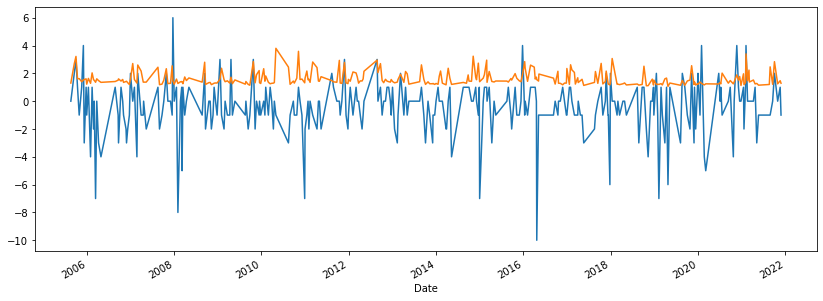

In [312]:
fig, ax = plt.subplots(figsize=(14, 5))
df[df["HomeTeam"]=="Liverpool"]["AStreak"].plot(ax=ax)
df[df["HomeTeam"]=="Liverpool"]["oddsH"].plot(ax=ax)

(array([4.233e+03, 1.040e+03, 4.700e+02, 2.730e+02, 1.290e+02, 3.800e+01,
        2.000e+01, 3.000e+00, 5.000e+00, 3.000e+00]),
 array([ 1.12333333,  4.37766667,  7.632     , 10.88633333, 14.14066667,
        17.395     , 20.64933333, 23.90366667, 27.158     , 30.41233333,
        33.66666667]),
 <BarContainer object of 10 artists>)

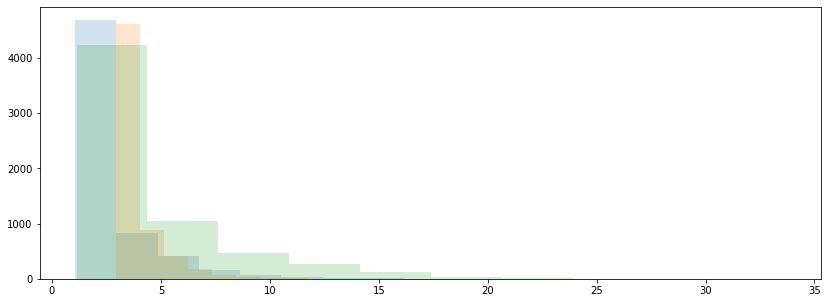

In [313]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.hist(df["oddsH"], alpha=0.2)
ax.hist(df["oddsD"], alpha=0.2)
ax.hist(df["oddsA"], alpha=0.2)

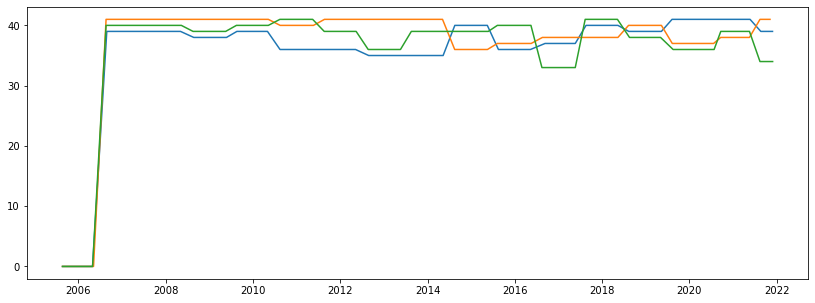

In [314]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df[df["HomeTeam"] == "Liverpool"]["HPrevPos"])
ax.plot(df[df["HomeTeam"] == "Man United"]["HPrevPos"])
ax.plot(df[df["HomeTeam"] == "Chelsea"]["HPrevPos"])

In [315]:
def standardize(df, team, col):
    tmp = df.copy()
    seasons = tmp.Season.unique()
    for season in seasons:
        tmp_season = tmp.loc[tmp["Season"] == season]
        teams_per_season = tmp_season[team].unique()
        count = 0
        for t in teams_per_season:
            tmp_team = tmp_season.loc[tmp_season[team] == t]
            standardized = []
            for idx, row in tmp_team.iterrows():
                if count == 0:
                    tmp.loc[idx, col] = 0
                else:
                    tmp.loc[idx, col] /= count
                count += 1
            count = 0
    return tmp

In [317]:
for col in ['HTGSCum', 'HTGCCum', 'HTGDCum', 'HTPCum', 'HSCum', 'HSTCum',
       'HFCum', 'HCCum', 'HYCum', 'HRCum', 'PtDiffCum']:
    df_final = standardize(df_final, "HomeTeam", col)

In [318]:
for col in ['ATGSCum', 'ATGCCum', 'ATGDCum', 'ATPCum', 'ASCum', 
            'ASTCum', 'AFCum', 'ACCum', 'AYCum', 'ARCum']:
    df_final = standardize(df_final, "AwayTeam", col)

In [320]:
df_final.head(100)

,Season,Date,Date_interval,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,...,HRCum,ARCum,PtDiffCum,HStreak,AStreak,HPrevPos,APrevPos,oddsH,oddsD,oddsA
0,2005/2006,2005-08-13,2005-08-13,Aston Villa,Bolton,2,2,D,2,2,...,0.0,0.00,0.00,0,0,0.0,0.0,2.166667,3.166667,3.083333
1,2005/2006,2005-08-13,2005-08-13,Everton,Man United,0,2,A,0,2,...,0.0,0.00,0.00,0,0,0.0,0.0,4.383333,3.283333,1.756667
2,2005/2006,2005-08-13,2005-08-13,Fulham,Birmingham,0,0,D,0,0,...,0.0,0.00,0.00,0,0,0.0,0.0,2.290000,3.150000,2.856667
3,2005/2006,2005-08-13,2005-08-13,Man City,West Brom,0,0,D,0,0,...,0.0,0.00,0.00,0,0,0.0,0.0,1.690000,3.350000,4.666667
4,2005/2006,2005-08-13,2005-08-13,Middlesbrough,Liverpool,0,0,D,0,0,...,0.0,0.00,0.00,0,0,0.0,0.0,2.756667,3.183333,2.366667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2005/2006,2005-10-23,2005-10-29,West Ham,Middlesbrough,2,1,H,2,5,...,0.0,0.00,0.75,0,1,0.0,0.0,2.306667,3.150000,2.823333
96,2005/2006,2005-10-29,2005-10-29,Birmingham,Everton,0,1,A,0,2,...,0.2,0.20,-2.40,-1,-4,0.0,0.0,2.150000,3.133333,3.166667
97,2005/2006,2005-10-29,2005-10-29,Charlton,Bolton,0,1,A,0,3,...,0.0,0.20,-0.75,0,-2,0.0,0.0,2.050000,3.150000,3.366667
98,2005/2006,2005-10-29,2005-10-29,Chelsea,Blackburn,4,2,H,5,2,...,0.0,0.40,4.20,5,-1,0.0,0.0,1.213333,5.266667,12.166667


In [321]:
df_final.columns

Index(['Season', 'Date', 'Date_interval', 'HomeTeam', 'AwayTeam', 'FTHG',
       'FTAG', 'FTR', 'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTGD', 'ATGD', 'HS',
       'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR',
       'HTP', 'ATP', 'PtDiff', 'HTGSCum', 'ATGSCum', 'HTGCCum', 'ATGCCum',
       'HTGDCum', 'ATGDCum', 'HTPCum', 'ATPCum', 'HSCum', 'ASCum', 'HSTCum',
       'ASTCum', 'HFCum', 'AFCum', 'HCCum', 'ACCum', 'HYCum', 'AYCum', 'HRCum',
       'ARCum', 'PtDiffCum', 'HStreak', 'AStreak', 'HPrevPos', 'APrevPos',
       'oddsH', 'oddsD', 'oddsA'],
      dtype='object')

In [322]:
df_final.to_csv("use_this_data.csv")